In [1]:
import json
from resources import WorkforceResource
from graph import Graph
from task import Task
from utils import bfs
import matplotlib.pyplot as plt
import numpy as np

# Initial

## Load workforce

In [2]:


color_map = plt.get_cmap('Set1')  # Choose a color map


In [3]:
WORKFORCE_DATA_PATH = '/Users/pvm/Desktop/Đồ Án/data/workforces.json'
f = open(WORKFORCE_DATA_PATH, 'rb')
workforces = json.load(f)

LIST_WORKFORCE = [
    WorkforceResource( 
        workforce_id = workforces[w]['id'],
        salary_unit = workforces[w]['salary_unit'],
        skills = workforces[w]['skills'])
        for w in workforces
    ]


for i in range(len(LIST_WORKFORCE)):
    LIST_WORKFORCE[i].set_color(color_map(i / len(LIST_WORKFORCE)))

## Load Tasks

In [4]:
import json
schedule_data_path = 'data/schedule.json'

f = open(schedule_data_path, 'rb')
schedule = json.load(f)

In [5]:
# Create an instance of the Graph class
graph = Graph()
list_task = [
     Task(
        task_id = schedule[t_name]['Tid'], 
        duration=  schedule[t_name]['duration'], 
        required_skills = schedule[t_name]['required_skills'] , 
        required_equipments = schedule[t_name]['required_equipments'],
        pred_tasks = schedule[t_name]['pred']
        )

    for t_name in schedule.keys()]


for task in list_task:
    
    if task.task_id == 'START':
        graph.set_start_node(start_node = task)

    if task.task_id == 'END':
        graph.set_finish_node(finish_node = task)
  
    # print(f"task_name: {task.task_id} | task.pred_tasks: {task.pred_tasks}")
    for pred_task_name in task.pred_tasks:
        pred_task = list(filter(lambda x: (x.task_id == pred_task_name), list_task))[0]
        graph.addEdge(u = pred_task , v = task)
   

In [6]:
for task in graph.get_list_task():
    print(task.info())

{'task_id': 'T1.2', 'duration': 5, 'required_skills': ['S1_4', 'S2_2', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': None, 'finish_time': None}
{'task_id': 'T1.3', 'duration': 5, 'required_skills': ['S5_1', 'S3_5', 'S4_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': None, 'finish_time': None}
{'task_id': 'T1.4', 'duration': 5, 'required_skills': ['S1_6', 'S2_1', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': None, 'finish_time': None}
{'task_id': 'T1.5', 'duration': 2, 'required_skills': ['S1_1', 'S3_5', 'S4_5'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': None, 'finish_time': None}
{'task_id': 'START', 'duration': 0, 'required_skills': [], 'required_equipments': [], 'start_time': 0, 'finish_time': 0}
{'task_id': 'T1.6', 'duration': 1, 'required_skills': ['S1_1', 'S5_1', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': None, 'finish_time': None}
{'task_id': 'T1.1', 'duration

In [7]:
list_task

In [8]:
bfs(graph = graph, start_node = graph.start_node)

In [9]:
task_workforce_cost = [[task.duration*workforce.salary_unit for workforce in LIST_WORKFORCE] for task in list_task]

In [10]:
def compute_skill_mapping(task: Task, workforce: WorkforceResource):
    mapping = 0.000001
    if task.task_id not in ['START', 'END']:

        required_skills = [(skill.split("_")[0],skill.split("_")[1])  for skill in task.required_skills]
        workforce_skills =  [(skill.split("_")[0],skill.split("_")[1])  for skill in workforce.skills]


        required_name_skills,  required_level_skills = zip(*required_skills)
        workforce_name_skills,  workforce_level_skills = zip(*workforce_skills)

        required_name_skills = list(required_name_skills)
        workforce_name_skills = list(workforce_name_skills)
        workforce_level_skills = list(workforce_level_skills)
        

        if len(list(set(required_name_skills) & set(workforce_name_skills))) >= len(required_name_skills):
            mapping = 0
            for i in range(len(required_name_skills)):
                req_level =  int(required_level_skills[i])
                skill_level = int(workforce_level_skills[workforce_name_skills.index(required_name_skills[i])])
                gap = skill_level -  req_level
                if gap < 0:
                    break
                mapping += gap
    return mapping

In [11]:
task_skill_level_mapping = [[compute_skill_mapping(task =task, workforce=workforce) for workforce  in LIST_WORKFORCE] for task in  list_task[1:-1]]


In [12]:
task_skill_level_mapping

[[3, 6, 3, 1e-06, 6, 1e-06, 1e-06, 1e-06, 1e-06, 10],
 [0, 0, 0, 1e-06, 0, 1e-06, 1e-06, 1e-06, 1e-06, 6],
 [1e-06, 3, 2, 2, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06],
 [0, 0, 0, 1e-06, 0, 1e-06, 1e-06, 1e-06, 1e-06, 0],
 [1, 1, 1, 1, 1e-06, 1e-06, 1e-06, 3, 1, 1e-06],
 [1e-06, 7, 4, 4, 1e-06, 1e-06, 7, 1e-06, 1e-06, 1e-06],
 [1, 1, 1, 1, 1e-06, 1e-06, 1e-06, 7, 5, 1e-06]]

In [13]:
skill_vocab = []
for task in list_task:
    skill_vocab.extend([skill.split("_")[0] for skill in task.required_skills])

skill_vocab = list(set(skill_vocab))

skill_vocab.sort()

In [14]:
req_skill_matrix = []

for task in list_task:
    skill_vec = []
    if task.task_id not in ['START', 'END']:
        required_skills = [(skill.split("_")[0],skill.split("_")[1])  for skill in  task.required_skills]
        required_name_skills,  required_level_skills = zip(*required_skills)

        required_name_skills = list(required_name_skills)
        required_level_skills = list(required_level_skills)

        req_skills =  task.required_skills
        for skill in skill_vocab:
            if skill not in required_name_skills:
                skill_vec.append(0)
            else:
                skill_vec.append( int(required_level_skills[required_name_skills.index(skill)]))
  
        req_skill_matrix.append(skill_vec)

print(f"Shape req.skill matrix: ({len(req_skill_matrix)},{len(req_skill_matrix[0])})")

Shape req.skill matrix: (7,5)


In [15]:
from similarity import calculate_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from graph import Graph
from task import Task
from utils import update_overlap_bfs, bfs, get_completed_time

In [16]:
req_skill_matrix

[[1, 1, 1, 0, 0],
 [4, 2, 1, 0, 0],
 [0, 0, 5, 1, 1],
 [6, 1, 1, 0, 0],
 [1, 0, 5, 5, 0],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 5, 0]]

In [17]:
task_task_similarity = calculate_similarity(req_skill_matrix = np.array((req_skill_matrix)))

In [18]:
task_task_similarity

array([[1.        , 0.27888668, 0.124226  , 0.14985373, 0.07484812,
        0.47140452, 0.04358136],
       [0.27888668, 1.        , 0.0340633 , 0.42744212, 0.03742406,
        0.16835876, 0.0340633 ],
       [0.124226  , 0.0340633 , 1.        , 0.0210482 , 0.19055398,
        0.15713484, 0.06351799],
       [0.14985373, 0.42744212, 0.0210482 , 1.        , 0.0305266 ,
        0.12617222, 0.03060126],
       [0.07484812, 0.03742406, 0.19055398, 0.0305266 , 1.        ,
        0.07484812, 0.20885012],
       [0.47140452, 0.16835876, 0.15713484, 0.12617222, 0.07484812,
        1.        , 0.04358136],
       [0.04358136, 0.0340633 , 0.06351799, 0.03060126, 0.20885012,
        0.04358136, 1.        ]])

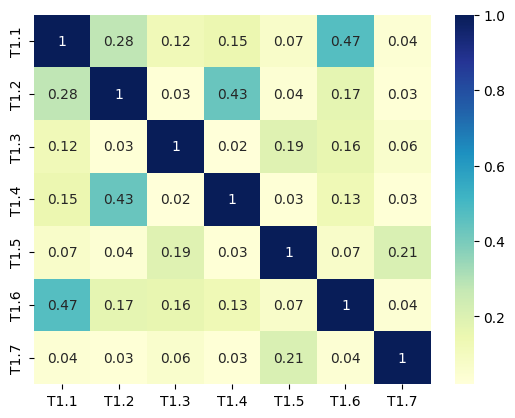

<Figure size 1000x600 with 0 Axes>

In [19]:
# Create a heatmap using Seaborn
sns.heatmap(
    np.round(task_task_similarity, 2), 
    annot=True, 
    cmap="YlGnBu", 
    xticklabels=[task.task_id for task in list_task[1:-1]], 
    yticklabels=[task.task_id for task in list_task[1:-1]])


# Set up the figure size
plt.figure(figsize=(10, 6))

# Display the heatmap

plt.show()

# Contraints

In [20]:
# Workforce not performance same time unit at more one task
def avaibale_workforce_contraints():
    # workforce must avaiable at timepoint (available in workloads, available in workschedule)
    pass


# Required skills on task must exited on workforce's skills and workforce's level skills must >= Required level skills
def avaibale_skills_contraints(required_skills, workforce_skills):
    pass

def avaibale_equipments_contraints(required_equipments, equipment_inventory):
    # Required equipments on task must equal equipments assigned

    # Equipments must avaiable at time unit on task
    pass


# Complete time must <= Deadline
def deadline_contraints(end_time, deadline):
    pass

# Objectives

# NSGA2

In [21]:
import pandas as pd
import numpy as np
import time
import pandas as pd
import copy

## Apply NSGA2

In [22]:
list_task

In [23]:
# Initial Resouces
NUM_WORKFORCE = len(LIST_WORKFORCE)
NUM_TASK = len(list_task[1:-1])

# Initial NSGA2 params
POPULATION_SIZE = 100
NUMBER_ITERATION = 50
CROSSOVER_RATE = 0.8

MUTATION_RATE = 0.4
MUTATION_SELECTION_RATE = 0.4


### Initial workforce to task

In [24]:
import numpy as np

population_list = np.empty((POPULATION_SIZE, NUM_TASK), dtype=int)
for i in range(POPULATION_SIZE):
    population_list[i] = np.random.choice(NUM_WORKFORCE, size=NUM_TASK, replace=True)


print(f"popular shape: {population_list.shape}")

popular shape: (300, 7)


### NSGA2 Method

In [25]:
def crossover(population_list):
    cosssover_offspring = [] # danh sách con cái được tạo ra từ crossover
    # Lấy ngẫu nhiên 2 parents
    random_parent_indices = list(np.random.permutation(POPULATION_SIZE)) # generate a random sequence to select the parent chromosome to crossover
    
    for m in range(int(POPULATION_SIZE/2)):
        parent_1= population_list[random_parent_indices[2*m]][:]

        parent_2= population_list[random_parent_indices[2*m+1]][:]
        child_1=parent_1[:]
        child_2=parent_2[:]
        
        # Lấy ngẫu nhiên 2 đoạn bất kỳ trong parent 1 chuyển cho parent 2
        cutpoint=list(np.random.choice(NUM_TASK, 2, replace=False))
        cutpoint.sort()
        child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
        child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
        
        cosssover_offspring.extend((child_1,child_2))
    return cosssover_offspring




def mutation(offspring_list):
    num_mutation_jobs = round(NUM_TASK*MUTATION_SELECTION_RATE)
    # Thực hiện đảo ngược 1 gen
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if MUTATION_RATE <= mutation_prob:
            # chooses the position to mutation
            m_chg=list(np.random.choice(NUM_TASK, num_mutation_jobs, replace=False))
            # save the value which is on the first mutation position
            
            t_value_last=offspring_list[m][m_chg[0]] 
            
            for i in range(num_mutation_jobs-1):
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] # displacement
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last

    return offspring_list

    

### Objective

In [26]:
def non_dominated_sorting(population_size, chroms_obj_record):
    s, n = {}, {}
    front, rank = {}, {}
    front[0] = []

    for p in range(population_size * 2):
        s[p] = []
        n[p] = 0
        for q in range(population_size * 2):
            is_dominated = False
            dominated_count = 0
            for obj in range(len(chroms_obj_record[p])):
                if chroms_obj_record[p][obj] > chroms_obj_record[q][obj]:
                    dominated_count += 1
                elif chroms_obj_record[p][obj] < chroms_obj_record[q][obj]:
                    is_dominated = True
                    break
            
            if is_dominated:
                if q not in s[p]:
                    s[p].append(q)

            elif not is_dominated and dominated_count == len(chroms_obj_record[p]):
                n[p] = n[p] + 1

        
        if n[p] == 0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while front[i] != []:
        Q = []
        for p in front[i]:
            for q in s[p]:
                n[q] = n[q] - 1
                if n[q] == 0:
                    rank[q] = i + 1
                    if q not in Q:
                        Q.append(q)
        i = i + 1
        front[i] = Q
    del front[len(front) - 1]
    return front


def calculate_crowding_distance(front,chroms_obj_record):
    
    distance={m:0 for m in front}
    for o in range(4):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])
            
    return distance  

In [27]:
obj = {1:5, 2:1, 3:2}
sorted(obj, key=obj.get)

[2, 3, 1]

In [28]:
def selection(front,chroms_obj_record,total_chromosome):   
    N=0
    new_pop=[]
    while N < POPULATION_SIZE:
        for i in range(len(front)):
            N=N+len(front[i])
            if N > POPULATION_SIZE:
                # Compare on each front after append solution with higher distance to new_pop
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==POPULATION_SIZE:
                        break                
                    new_pop.append(j)              
                break
            else:
                new_pop.extend(front[i])
    
    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])
    
    return population_list,new_pop

In [29]:


def cost_obj(chromosome):
    workforce_cost = 0
    equipment_cost = 0
    for n in range(len(chromosome)):
        workforce_cost += task_workforce_cost[n][chromosome[n]]
        equipment_cost = 0    
    return equipment_cost + workforce_cost


def assigned_level_obj(chromosome):
    skill_level_total = 0.0000000001
    for n in range(len(chromosome)):
        skill_level_total += task_skill_level_mapping[n][chromosome[n]]
    return skill_level_total

def group_by_same_resource(lst):
    indices = {}
    for i, value in enumerate(lst):
        if value in indices:
            indices[value].append(i)
        else:
            indices[value] = [i]
    return indices


def generate_indices_from_values(values):
    indices = []
    for i in range(len(values) - 1):
        for j in range(i + 1, len(values)):
            indices.append((values[i], values[j]))
    return indices

def compute_simality_assigned_tasks(tasks_indices):
    similar_score = 0.0000000001
    pair_tasks = generate_indices_from_values(tasks_indices)
    if len(tasks_indices) > 1:
        for pair in pair_tasks:
            similar_score += task_task_similarity[pair[0]][pair[1]]

    return similar_score/len(tasks_indices)

def similarity_task_obj(chromosome):
    simality_score = 0.0000000001
    grouped_resources = group_by_same_resource(chromosome)
    for resouce in grouped_resources.keys():
        
        simality_score += compute_simality_assigned_tasks(grouped_resources[resouce])
    return simality_score/len(list(grouped_resources.keys()))


def complete_time_obj(graph_copy: Graph, list_task_copy, list_workforce_copy, chromosome):
    bfs(graph_copy, start_node = graph.start_node)
    for i in range(len(chromosome)):
        graph_copy.assign(
                task_id =list_task_copy[i].task_id,
                workforce = list_workforce_copy[chromosome[i]])
        
    # print(graph_copy.assigned_workforce)
    return get_completed_time(graph_copy, start_node = graph_copy.start_node, list_workforce=list_workforce_copy  )    

    

### Fitness

In [30]:
def compute_fitness(graph_copy, list_task_copy, list_workforce_copy, total_chromosome):
    chroms_obj_record={} 
    for m in range(POPULATION_SIZE*2):
        # print(total_chromosome[m])
        cost = cost_obj(total_chromosome[m])
        assigned_level = assigned_level_obj(total_chromosome[m])
        similarity_task = similarity_task_obj(total_chromosome[m])


        complete_time = complete_time_obj(
            graph_copy = graph_copy, 
            list_workforce_copy  = list_workforce_copy, 
            list_task_copy  = list_task_copy, 
            chromosome = total_chromosome[m])
      
        chroms_obj_record[m]=[1/cost, assigned_level, similarity_task, 1/complete_time]

    return chroms_obj_record

### Run

In [31]:
start_time = time.time() 

best_list,best_obj=[],[]
for n in range(NUMBER_ITERATION):         

    parent_list=copy.deepcopy(population_list)
    offspring_list=[] # danh sách children
    
    # Crossover
    crossover_offspring = crossover(population_list = population_list)
    offspring_list.extend(crossover_offspring)

    # Mutation
    offspring_list = mutation(offspring_list = offspring_list)
    
    # Selection
    total_chromosome= copy.deepcopy(np.concatenate((parent_list, np.array(offspring_list))))
    chroms_obj_record = compute_fitness(
        total_chromosome = total_chromosome,
        list_task_copy = copy.deepcopy(list_task[1:-1]),
        list_workforce_copy= copy.deepcopy(LIST_WORKFORCE),
        graph_copy = copy.deepcopy(graph)
     )
    front=non_dominated_sorting(POPULATION_SIZE,chroms_obj_record)
 
    population_list,new_pop=selection(front,chroms_obj_record,total_chromosome)

    
    new_pop_obj=[chroms_obj_record[k] for k in new_pop] 
    
    # Comparison
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    else:            
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
        
        now_best_front=non_dominated_sorting(POPULATION_SIZE,total_obj)
        best_list,best_pop=selection(now_best_front,total_obj,total_list)
        best_obj=[total_obj[k] for k in best_pop]


print('-----Results -----------------------------')
print("One chromosome(1x100)=",best_list[0])
print("best_obj=",best_obj[0])
print("------------------------------------------")
print('The elapsed time:%s'% (time.time() - start_time))

-----Results -----------------------------
One chromosome(1x100)= [7 7 7 7 7 7 7]
best_obj= [0.003968253968253968, 10.0000050001, 0.39871237616621535, 0.03333333333333333]
------------------------------------------
The elapsed time:175.34442901611328


In [38]:
best_obj

[[0.003968253968253968,
  10.0000050001,
  0.39871237616621535,
  0.03333333333333333],
 [0.0048543689320388345, 5.000099999999999e-06, 0.05349225162882574, 0.05],
 [0.004310344827586207,
  35.0000010001,
  0.05735899922001234,
  0.03333333333333333],
 [0.0048543689320388345, 5.000099999999999e-06, 0.05349225162882574, 0.0625],
 [0.005952380952380952,
  8.0000030001,
  0.39871237616621535,
  0.03333333333333333],
 [0.004975124378109453,
  28.000000000100002,
  1.1428571428571428e-10,
  0.03333333333333333],
 [0.004149377593360996,
  31.000002000100004,
  0.055038233003548515,
  0.03333333333333333],
 [0.004149377593360996,
  6.0000050001,
  0.27991843598056704,
  0.03333333333333333],
 [0.0048543689320388345,
  5.000099999999999e-06,
  0.05349225162882574,
  0.058823529411764705],
 [0.0048543689320388345, 5.000099999999999e-06, 0.05349225162882574, 0.05],
 [0.0048543689320388345,
  5.000099999999999e-06,
  0.05349225162882574,
  0.05555555555555555],
 [0.0049504950495049506,
  3.000004

## Visualize

In [32]:
best_chromosome =  best_list[0]
graph_copy = copy.deepcopy(graph) 
list_task_copy =  copy.deepcopy(list_task[1:-1]) 

list_workforce_copy =  copy.deepcopy(LIST_WORKFORCE)  


bfs(graph_copy, start_node = graph_copy.start_node)
for i in range(len(best_chromosome)):
    graph_copy.assign(
            task_id =list_task_copy[i].task_id,
            workforce = list_workforce_copy[best_chromosome[i]])

update_overlap_bfs(graph_copy, start_node = graph_copy.start_node, list_workforce = None)


30

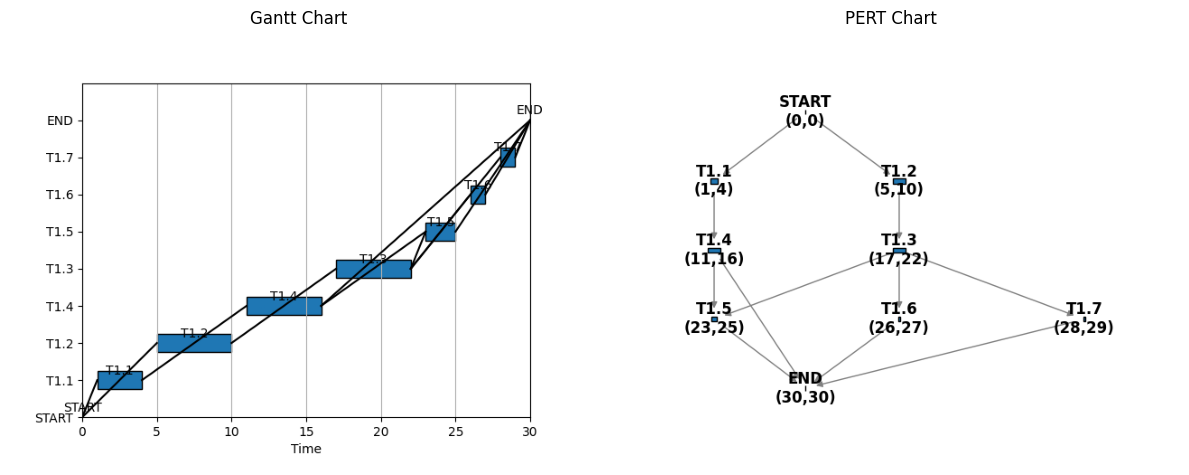

In [33]:
graph_copy.visualizeCharts()

In [34]:
for task in graph.graph:
    print(task.info())

{'task_id': 'START', 'duration': 0, 'required_skills': [], 'required_equipments': [], 'start_time': 0, 'finish_time': 0}
{'task_id': 'T1.2', 'duration': 5, 'required_skills': ['S1_4', 'S2_2', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': 1, 'finish_time': 6}
{'task_id': 'T1.1', 'duration': 3, 'required_skills': ['S1_1', 'S2_1', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': 1, 'finish_time': 4}
{'task_id': 'T1.4', 'duration': 5, 'required_skills': ['S1_6', 'S2_1', 'S3_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': 5, 'finish_time': 10}
{'task_id': 'T1.3', 'duration': 5, 'required_skills': ['S5_1', 'S3_5', 'S4_1'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': 7, 'finish_time': 12}
{'task_id': 'T1.5', 'duration': 2, 'required_skills': ['S1_1', 'S3_5', 'S4_5'], 'required_equipments': ['E1_1', 'E2_1', 'E3_1'], 'start_time': 13, 'finish_time': 15}
{'task_id': 'T1.6', 'duration': 1, 'required_skills': [

KeyError: 'T1.2'

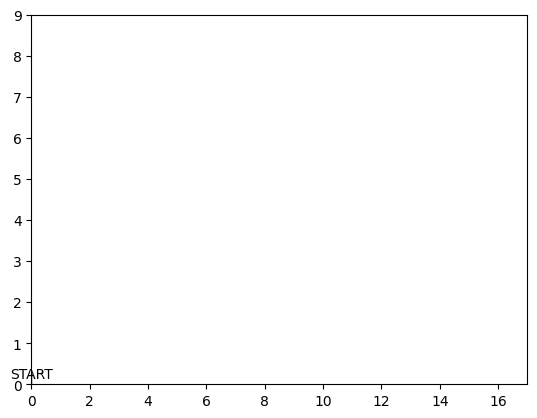

In [35]:
graph.visualizeCharts()